## Hyperparameter Tuning

The hyperparameters in deep learning to tune are 
- the number of neurons
- activation function
- optimiser
- learning rate
- batch size
- epochs 
- number of layers.


Reference: 
- https://www.analyticsvidhya.com/blog/2021/05/tuning-the-hyperparameters-and-layers-of-neural-network-deep-learning/

In [2]:
from typing import List, Optional, Callable
import os
import sys
from tqdm import tqdm
import logging
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import transforms
from torchvision.models import efficientnet_b5, EfficientNet_B5_Weights

from ray import tune
from ray.tune.search.optuna import OptunaSearch
from ray.tune.schedulers import ASHAScheduler

# determine the project root - required to import DataHandler from utils folder
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

modelName = "efficientNetAccuracy"

# configuring log file
log_dir = os.path.join(project_root, "logs")
os.makedirs(log_dir, exist_ok=True)
log_filename = os.path.join(log_dir, F"{modelName}_training_log.txt") #NOTE: specify based on model training

logging.basicConfig(
    filename=log_filename,
    filemode="w",  #NOTE: previous logs would be overwritten
    format="%(asctime)s %(levelname)s: %(message)s",
    level=logging.INFO
)

MODEL_SAVE_DIR = os.path.join(project_root, "models", modelName)
os.makedirs(MODEL_SAVE_DIR, exist_ok=True) 

LOSS_RESULTS_SAVE_DIR = os.path.join(project_root, "results", F"{modelName}_loss")
os.makedirs(LOSS_RESULTS_SAVE_DIR, exist_ok=True) 

ACC_RESULTS_SAVE_DIR = os.path.join(project_root, "results", F"{modelName}_acc")
os.makedirs(ACC_RESULTS_SAVE_DIR, exist_ok=True) 

from utils.DataHandler import download_dataset, create_full_data_loaders, create_tuning_data_loaders

c:\Users\yongl\anaconda3\envs\ADLTEAM\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-19 14:34:34,657	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-04-19 14:34:34,790	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [3]:
def get_device():
    if torch.cuda.is_available():
        print("Using device: CUDA (GPU)")
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        print("Using device: MPS (Apple Silicon GPU)")
        os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
        return torch.device("mps")
    else:
        print("Using device: CPU")
        return torch.device("cpu")

device = get_device()

Using device: CUDA (GPU)


## Data Download
This is adapted from SeparatingData.ipynb
Download the processed dataset from Google Drive if yet to.

In [ ]:
# DATA_DIR = "../input/final_split_training_augmented"
# ZIP_URL = "https://drive.google.com/uc?id=11t8m703wcNss3w5diJSUGBA_vXnCKChr"
# ZIP_FILENAME = "../input/final_split.zip"
# ROOT_DIR = "../input"

# download_dataset(DATA_DIR, ZIP_URL, ZIP_FILENAME, ROOT_DIR)

Dataset already exists at ../input/final_split_training_augmented


## Subset Data Load
For faster hyperparameter tuning, use a subset of the dataset to find the most optimised set of hyperparameters.
Loads dataset from processed dataset which should have been split to train, test, eval.

In [4]:
SPLIT_DATASET = os.path.abspath("../../input/final_split_15Apr2025")
BATCH_SIZE = 64

# Define data transformation 
# in this notebook, we are doing it for EfficientNetB5, so we resize to ~456x456
weights = EfficientNet_B5_Weights.DEFAULT
transform = transforms.Compose([
    transforms.Resize((456, 456)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    weights.transforms()
])

TRAIN_LOADER, VAL_LOADER, TEST_LOADER = create_tuning_data_loaders(
    dataset_root=SPLIT_DATASET,
    transform=transform,
    batch_size=BATCH_SIZE,
    subset_fraction=0.5,
    random_seed=42
)

Using pre-split datasets: train 8025, val 579, test 572
Created tuning data loaders with subset fraction: 0.5
Created subset datasets for hyperparameter tuning: train 4012, val 289, test 572
Class Distribution for Subset Training:
  angry     : 983
  happy     : 1039
  relaxed   : 1024
  sad       : 966
Class Distribution for Subset Validation:
  angry     : 71
  happy     : 75
  relaxed   : 74
  sad       : 69


## Full Data Load
When doing the entire training for the entire dataset (full dataset not used in hyperparameter tuning)

In [5]:
FULL_TRAIN_LOADER, FULL_VAL_LOADER, FULL_TEST_LOADER = create_full_data_loaders(
    dataset_root=SPLIT_DATASET,
    transform=transform,
    batch_size=BATCH_SIZE,
)

Using pre-split datasets: train 8025, val 579, test 572


## Model Specifications
This is where you should replace with your model.

EfficientNetB5 Partial Transfer Learning:
- https://discuss.pytorch.org/t/partial-transfer-learning-efficientnet/109689 

In [6]:
class SqueezeExcitationBlock(nn.Module):
    def __init__(self, channels, reduction_ratio=16):
        super(SqueezeExcitationBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.interaction = nn.Sequential(
            nn.Linear(channels, channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction_ratio, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.interaction(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


class BaseEfficientNetB5(nn.Module):
    """
    EfficientNetB5 with optional SE block and configurable classifier for Ray Tune.
    """
    def __init__(self,
                 num_classes: int = 4,
                 dropout: float = 0.2,
                 hidden_sizes: Optional[List[int]] = None,
                 activation: str = 'relu',
                 use_se: bool = True,
                 unfreeze_blocks: Optional[List[int]] = None) -> None:
        super(BaseEfficientNetB5, self).__init__()
        weights = EfficientNet_B5_Weights.DEFAULT
        self.backbone = efficientnet_b5(weights=weights)
        in_features = self.backbone.classifier[1].in_features

        for param in self.backbone.features.parameters():
            param.requires_grad = False

        if unfreeze_blocks:
            for idx in unfreeze_blocks:
                for param in self.backbone.features[idx].parameters():
                    param.requires_grad = True

        # Build the classifier head
        layers = []
        if use_se:
            layers.extend([
                nn.Unflatten(1, (in_features, 1, 1)),
                SqueezeExcitationBlock(in_features),
                nn.Flatten()
            ])
        
        input_dim = in_features
        if hidden_sizes:
            for hidden_dim in hidden_sizes:
                layers.append(nn.Dropout(p=dropout))
                layers.append(nn.Linear(input_dim, hidden_dim))
                layers.append(self._get_activation(activation))
                input_dim = hidden_dim
        
        layers.append(nn.Dropout(p=dropout))
        layers.append(nn.Linear(input_dim, num_classes))

        self.backbone.classifier[1] = nn.Sequential(*layers)

    def _get_activation(self, activation: str) -> Callable:
        if activation.lower() == 'relu':
            return nn.ReLU()
        elif activation.lower() == 'tanh':
            return nn.Tanh()
        elif activation.lower() == 'sigmoid':
            return nn.Sigmoid()
        else:
            raise ValueError(f"Unsupported activation function: {activation}")
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.backbone(x)

In [7]:
print(f"Using device: {device}")
model = BaseEfficientNetB5(num_classes=4, dropout=0.3, hidden_sizes=[256, 128], activation='relu', unfreeze_blocks=[7]).to(device)
print("Model instantiated:", model.__class__.__name__)
print(model)

Using device: cuda
Model instantiated: BaseEfficientNetB5
BaseEfficientNetB5(
  (backbone): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
              (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))

## Hyperparameter Tuning
This is the part where you write the training function and load it to the ray tune scheduler.
For this execution, ASHAscheduler is used with Optuna for bayesian optimisation techniques - which should be using the default Tree-Structured Parzen Estimator.
If many parameters, this is would be more efficient than grid search and random search.

References:
- https://docs.ray.io/en/latest/tune/examples/includes/async_hyperband_example.html
- https://docs.ray.io/en/latest/tune/examples/tune-pytorch-cifar.html 
- https://docs.ray.io/en/latest/tune/examples/includes/mnist_pytorch.html
- https://docs.ray.io/en/latest/tune/api/suggestion.html

In [7]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from ray import tune

CHECKPOINT_DIR = os.path.abspath(F"../../models/hyptune/{modelName}")
def train_model(config, checkpoint_dir=CHECKPOINT_DIR, data_dir=None):
    """Training function for Ray Tune hyperparameter tuning.

    This function instantiates the model with hyperparameters
    specified in the config dictionary, trains the model on the global TRAIN_LOADER,
    evaluates on VAL_LOADER, and reports the validation loss to Ray Tune.

    Args:
        config (dict): Hyperparameter configuration. Expected keys include:
            - lr (float): Learning rate.
            - weight_decay (float): Weight decay for the optimizer.
            - dropout (float): Dropout rate for the classifier.
            - hidden_sizes (list or None): List of hidden layer sizes in the classifier.
            - activation (str): Activation function to use ('relu', 'tanh', etc.).
            - freeze_backbone (bool): Whether to freeze the model backbone.
            - num_epochs (int): Number of training epochs.
            - optimiser (callable, optional): Optimiser class. Default is optim.Adam.
            - criterion (callable, optional): Loss function instance. Default is nn.CrossEntropyLoss().
        checkpoint_dir (str, optional): Directory for checkpointing (if applicable).
        data_dir (str, optional): Not used here; included for compatibility.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"

    if checkpoint_dir:
        os.makedirs(checkpoint_dir, exist_ok=True)
        print(f"Checkpoint Folder exists")
    
    # instantiate model with hyperparameters from config
    model = BaseEfficientNetB5(
        num_classes=4,
        dropout=config.get("dropout", 0.3),
        hidden_sizes=config.get("hidden_sizes", None),
        activation=config.get("activation", "relu"),
        unfreeze_blocks = config.get("unfreeze_blocks", [7])
    ).to(device)

    optimiser = config["optimiser"](model.parameters(), config["lr"], config["weight_decay"])
    criterion = config["criterion"]()

    num_epochs = config.get("num_epochs", 2)  # a low number for quick tuning, but update accordingly
    
    # training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss, running_correct, running_total = 0.0, 0, 0 #UPDATE: add this line for accuracy
        for inputs, targets in tqdm(TRAIN_LOADER, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, targets = inputs.to(device), targets.to(device)
            optimiser.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimiser.step()
            running_loss += loss.item() * inputs.size(0)
            running_correct += (outputs.argmax(1) == targets).sum().item()  #UPDATE: add this line for accuracy
            running_total   += targets.size(0)  #UPDATE: add this line for accuracy
        
        epoch_loss = running_loss / len(TRAIN_LOADER.dataset)
        epoch_acc  = running_correct / running_total
        print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")
        print(f"[TRAIN] epoch {epoch+1}: loss={epoch_loss:.4f} acc={epoch_acc:.3f}")  #UPDATE: edit this line for accuracy

        # optionally, can checkpoint the model
        if checkpoint_dir:
            path = os.path.join(checkpoint_dir, f"checkpoint_{epoch}.pt")
            torch.save(model.state_dict(), path)
    
    # evaluation on the subset validation set
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0 #UPDATE: add this line for accuracy
    with torch.no_grad():
        for inputs, targets in VAL_LOADER:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0) #UPDATE: edit this variable name
            val_correct += (outputs.argmax(1) == targets).sum().item() #UPDATE: add this line for accuracy
            val_total   += targets.size(0) #UPDATE: add this line for accuracy
    
    avg_val_loss = val_loss / val_total
    avg_val_acc  = val_correct / val_total
    print(f"[VAL] loss={avg_val_loss:.4f} acc={avg_val_acc:.3f}") #UPDATE: edit this line for accuracy
    
    # Report the metric to Ray Tune
    tune.report({"loss": avg_val_loss, "acc": avg_val_acc}) #UPDATE: edit this line for accuracy

In [8]:
asha_scheduler = ASHAScheduler(
    time_attr='training_iteration',
    metric='loss',
    mode='min',
    max_t=100,           # max training iterations per trial
    grace_period=10,     # min iterations before stopping
    reduction_factor=3,
    brackets=1,
)

optuna_search = OptunaSearch(metric="loss", mode="min", seed=42)

# define search space in a config dictionary, i.e what are the values you want to try, this is just example of format
'''
config = {
    "lr": tune.loguniform(1e-5, 1e-2),
    "weight_decay": tune.loguniform(1e-6, 1e-2),
    "dropout": tune.uniform(0.1, 0.5),
    "hidden_sizes": tune.choice([[256, 128], [512, 256], None]),
    "activation": tune.choice(["relu", "tanh"]),
    "freeze_backbone": tune.choice([True, False]),
    "num_epochs": 2, 
    "optimiser": tune.choice([optim.Adam, optim.SGD]),
    "criterion": tune.choice([nn.CrossEntropyLoss, nn.NLLLoss]),
    "unfreeze_blocks": tune.choice([[7], [6, 7], [5, 6, 7]]),
}
'''

# this is what i specified for the example because i am running on cpu
# config = {
#     "lr": tune.loguniform(1e-5, 1e-2),
#     "weight_decay": tune.loguniform(1e-6, 1e-2),
#     "dropout": tune.uniform(0.1, 0.5),
#     "freeze_backbone": tune.choice([True]),
#     "num_epochs": 2,
# }


# for efficientnetb5 gpu
config = {
    "lr": tune.loguniform(1e-5, 5e-5),    
    "weight_decay": tune.loguniform(1e-5, 2e-5),
    "dropout": tune.uniform(0.39, 0.41),
    "hidden_sizes": tune.choice([[256, 128], [512, 256], None]),
    "activation": tune.choice(["relu", "tanh", "sigmoid", "leakyrelu"]), #Removed gelu
    "unfreeze_blocks": tune.choice([[6, 7]]),
    "num_epochs": 10,
    "optimiser": tune.choice([
        lambda params, lr, wd: optim.Adam(params, lr=lr, weight_decay=wd),
        lambda params, lr, wd: optim.SGD(params, lr=lr, momentum=0.9, weight_decay=wd)
    ]),
    "criterion": lambda: nn.CrossEntropyLoss()
}

def trial_dirname_creator(trial):
    # this is meant to create short and unique directory name for each trial bc else too long for windows
    # include a unique identifier (like trial.trial_id).
    return f"trial_{trial.trial_id}"

def trial_name_creator(trial):
    return f"t_{trial.trial_id}"

# tuner object
tuner = tune.Tuner(
    tune.with_resources(train_model, {"cpu": 12, "gpu": 1}), #NOTE:specify based on the device u using because by default it uses all, i.e if u have 4 cpus; it does 4 concurrent trials    
    tune_config=tune.TuneConfig( 
        scheduler=asha_scheduler, 
        search_alg=optuna_search, 
        num_samples=15,  # number of trials to run 
        trial_dirname_creator=trial_dirname_creator, 
        trial_name_creator=trial_name_creator,  
    ),

    run_config=tune.RunConfig(
        name=modelName,
        storage_path=F"C:/ray_results/{modelName}", #NOTE: not required for macos
        log_to_file=True,
        verbose=1),
    param_space=config,
)

results = tuner.fit()
print("Best config:", results.get_best_result(metric="acc", mode="max", filter_nan_and_inf=False).config) #UPDATE: edit this line to use accuracy

(train_model pid=24444) Checkpoint Folder exists


Epoch 1/10: 100%|██████████| 63/63 [01:05<00:00,  1.04s/it]


(train_model pid=24444) Epoch 1/10, Training Loss: 1.3881
(train_model pid=24444) [TRAIN] epoch 1: loss=1.3881 acc=0.248


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24444) Epoch 2/10, Training Loss: 1.3873
(train_model pid=24444) [TRAIN] epoch 2: loss=1.3873 acc=0.256


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24444) Epoch 3/10, Training Loss: 1.3863
(train_model pid=24444) [TRAIN] epoch 3: loss=1.3863 acc=0.259


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24444) Epoch 4/10, Training Loss: 1.3873
(train_model pid=24444) [TRAIN] epoch 4: loss=1.3873 acc=0.253


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24444) Epoch 5/10, Training Loss: 1.3876
(train_model pid=24444) [TRAIN] epoch 5: loss=1.3876 acc=0.263


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24444) Epoch 6/10, Training Loss: 1.3867
(train_model pid=24444) [TRAIN] epoch 6: loss=1.3867 acc=0.256


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24444) Epoch 7/10, Training Loss: 1.3870
(train_model pid=24444) [TRAIN] epoch 7: loss=1.3870 acc=0.260


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24444) Epoch 8/10, Training Loss: 1.3880
(train_model pid=24444) [TRAIN] epoch 8: loss=1.3880 acc=0.250


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24444) Epoch 9/10, Training Loss: 1.3864
(train_model pid=24444) [TRAIN] epoch 9: loss=1.3864 acc=0.261


Epoch 10/10: 100%|██████████| 63/63 [01:04<00:00,  1.02s/it]


(train_model pid=24444) Epoch 10/10, Training Loss: 1.3856
(train_model pid=24444) [TRAIN] epoch 10: loss=1.3856 acc=0.264


2025-04-19 11:35:59,559	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5e5b722a')}


(train_model pid=24444) [VAL] loss=1.3851 acc=0.263
(train_model pid=5272) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=5272) Epoch 1/10, Training Loss: 1.3883
(train_model pid=5272) [TRAIN] epoch 1: loss=1.3883 acc=0.262


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=5272) Epoch 2/10, Training Loss: 1.3913
(train_model pid=5272) [TRAIN] epoch 2: loss=1.3913 acc=0.250


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=5272) Epoch 3/10, Training Loss: 1.3878
(train_model pid=5272) [TRAIN] epoch 3: loss=1.3878 acc=0.267


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=5272) Epoch 4/10, Training Loss: 1.3881
(train_model pid=5272) [TRAIN] epoch 4: loss=1.3881 acc=0.261


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=5272) Epoch 5/10, Training Loss: 1.3874
(train_model pid=5272) [TRAIN] epoch 5: loss=1.3874 acc=0.268


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=5272) Epoch 6/10, Training Loss: 1.3861
(train_model pid=5272) [TRAIN] epoch 6: loss=1.3861 acc=0.265


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=5272) Epoch 7/10, Training Loss: 1.3840
(train_model pid=5272) [TRAIN] epoch 7: loss=1.3840 acc=0.271


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=5272) Epoch 8/10, Training Loss: 1.3819
(train_model pid=5272) [TRAIN] epoch 8: loss=1.3819 acc=0.282


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=5272) Epoch 9/10, Training Loss: 1.3810
(train_model pid=5272) [TRAIN] epoch 9: loss=1.3810 acc=0.291


Epoch 10/10: 100%|██████████| 63/63 [01:07<00:00,  1.07s/it]


(train_model pid=5272) Epoch 10/10, Training Loss: 1.3794
(train_model pid=5272) [TRAIN] epoch 10: loss=1.3794 acc=0.284


2025-04-19 11:46:59,054	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5e5b722a')}


(train_model pid=5272) [VAL] loss=1.3770 acc=0.363
(train_model pid=24580) Checkpoint Folder exists


2025-04-19 11:47:03,302	ERROR tune_controller.py:1331 -- Trial task failed for trial t_04f504c7
Traceback (most recent call last):
  File "c:\Users\yongl\anaconda3\envs\ADLTEAM\lib\site-packages\ray\air\execution\_internal\event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "c:\Users\yongl\anaconda3\envs\ADLTEAM\lib\site-packages\ray\_private\auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "c:\Users\yongl\anaconda3\envs\ADLTEAM\lib\site-packages\ray\_private\client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "c:\Users\yongl\anaconda3\envs\ADLTEAM\lib\site-packages\ray\_private\worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "c:\Users\yongl\anaconda3\envs\ADLTEAM\lib\site-packages\ray\_private\worker.py", line 929, in get_objects
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(ValueError): ray::Im

(train_model pid=17148) Epoch 1/10, Training Loss: 1.3915
(train_model pid=17148) [TRAIN] epoch 1: loss=1.3915 acc=0.236
(train_model pid=17148) Checkpoint Folder exists


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=17148) Epoch 2/10, Training Loss: 1.3923
(train_model pid=17148) [TRAIN] epoch 2: loss=1.3923 acc=0.223


Epoch 3/10: 100%|██████████| 63/63 [01:05<00:00,  1.05s/it]


(train_model pid=17148) Epoch 3/10, Training Loss: 1.3900
(train_model pid=17148) [TRAIN] epoch 3: loss=1.3900 acc=0.242


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=17148) Epoch 4/10, Training Loss: 1.3898
(train_model pid=17148) [TRAIN] epoch 4: loss=1.3898 acc=0.250


Epoch 5/10: 100%|██████████| 63/63 [01:05<00:00,  1.04s/it]


(train_model pid=17148) Epoch 5/10, Training Loss: 1.3925
(train_model pid=17148) [TRAIN] epoch 5: loss=1.3925 acc=0.229


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=17148) Epoch 6/10, Training Loss: 1.3894
(train_model pid=17148) [TRAIN] epoch 6: loss=1.3894 acc=0.251


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=17148) Epoch 7/10, Training Loss: 1.3916
(train_model pid=17148) [TRAIN] epoch 7: loss=1.3916 acc=0.228


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=17148) Epoch 8/10, Training Loss: 1.3878
(train_model pid=17148) [TRAIN] epoch 8: loss=1.3878 acc=0.256


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=17148) Epoch 9/10, Training Loss: 1.3869
(train_model pid=17148) [TRAIN] epoch 9: loss=1.3869 acc=0.245


Epoch 10/10: 100%|██████████| 63/63 [01:05<00:00,  1.03s/it]


(train_model pid=17148) Epoch 10/10, Training Loss: 1.3880
(train_model pid=17148) [TRAIN] epoch 10: loss=1.3880 acc=0.243


2025-04-19 11:58:07,191	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5e5b722a')}


(train_model pid=17148) [VAL] loss=1.3863 acc=0.228
(train_model pid=23564) Checkpoint Folder exists


Epoch 1/10:  98%|█████████▊| 62/63 [01:05<00:01,  1.05s/it]


(train_model pid=23564) Epoch 1/10, Training Loss: 1.3889
(train_model pid=23564) [TRAIN] epoch 1: loss=1.3889 acc=0.240


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=23564) Epoch 2/10, Training Loss: 1.3884
(train_model pid=23564) [TRAIN] epoch 2: loss=1.3884 acc=0.237


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=23564) Epoch 3/10, Training Loss: 1.3890
(train_model pid=23564) [TRAIN] epoch 3: loss=1.3890 acc=0.231


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=23564) Epoch 4/10, Training Loss: 1.3879
(train_model pid=23564) [TRAIN] epoch 4: loss=1.3879 acc=0.251


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=23564) Epoch 5/10, Training Loss: 1.3894
(train_model pid=23564) [TRAIN] epoch 5: loss=1.3894 acc=0.231


Epoch 6/10: 100%|██████████| 63/63 [01:05<00:00,  1.04s/it]


(train_model pid=23564) Epoch 6/10, Training Loss: 1.3883
(train_model pid=23564) [TRAIN] epoch 6: loss=1.3883 acc=0.239


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=23564) Epoch 7/10, Training Loss: 1.3887
(train_model pid=23564) [TRAIN] epoch 7: loss=1.3887 acc=0.243


Epoch 8/10: 100%|██████████| 63/63 [01:05<00:00,  1.04s/it]


(train_model pid=23564) Epoch 8/10, Training Loss: 1.3884
(train_model pid=23564) [TRAIN] epoch 8: loss=1.3884 acc=0.241


Epoch 9/10: 100%|██████████| 63/63 [01:05<00:00,  1.04s/it]


(train_model pid=23564) Epoch 9/10, Training Loss: 1.3889
(train_model pid=23564) [TRAIN] epoch 9: loss=1.3889 acc=0.240


Epoch 10/10: 100%|██████████| 63/63 [01:05<00:00,  1.04s/it]


(train_model pid=23564) Epoch 10/10, Training Loss: 1.3887
(train_model pid=23564) [TRAIN] epoch 10: loss=1.3887 acc=0.231


2025-04-19 12:09:15,294	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5e5b722a')}


(train_model pid=23564) [VAL] loss=1.3873 acc=0.270
(train_model pid=7632) Checkpoint Folder exists


Epoch 1/10: 100%|██████████| 63/63 [01:05<00:00,  1.04s/it]


(train_model pid=7632) Epoch 1/10, Training Loss: 1.3732
(train_model pid=7632) [TRAIN] epoch 1: loss=1.3732 acc=0.325


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=7632) Epoch 2/10, Training Loss: 1.3373
(train_model pid=7632) [TRAIN] epoch 2: loss=1.3373 acc=0.455


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=7632) Epoch 3/10, Training Loss: 1.2654
(train_model pid=7632) [TRAIN] epoch 3: loss=1.2654 acc=0.589


Epoch 4/10: 100%|██████████| 63/63 [01:05<00:00,  1.03s/it]


(train_model pid=7632) Epoch 4/10, Training Loss: 1.1230
(train_model pid=7632) [TRAIN] epoch 4: loss=1.1230 acc=0.673


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=7632) Epoch 5/10, Training Loss: 0.9557
(train_model pid=7632) [TRAIN] epoch 5: loss=0.9557 acc=0.747


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=7632) Epoch 6/10, Training Loss: 0.7958
(train_model pid=7632) [TRAIN] epoch 6: loss=0.7958 acc=0.779


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=7632) Epoch 7/10, Training Loss: 0.6624
(train_model pid=7632) [TRAIN] epoch 7: loss=0.6624 acc=0.813


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=7632) Epoch 8/10, Training Loss: 0.5619
(train_model pid=7632) [TRAIN] epoch 8: loss=0.5619 acc=0.843


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=7632) Epoch 9/10, Training Loss: 0.4769
(train_model pid=7632) [TRAIN] epoch 9: loss=0.4769 acc=0.862


Epoch 10/10: 100%|██████████| 63/63 [01:04<00:00,  1.03s/it]


(train_model pid=7632) Epoch 10/10, Training Loss: 0.4057
(train_model pid=7632) [TRAIN] epoch 10: loss=0.4057 acc=0.887


2025-04-19 12:20:16,118	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=7632) [VAL] loss=0.4838 acc=0.824
(train_model pid=14236) Checkpoint Folder exists


Epoch 1/10: 100%|██████████| 63/63 [01:05<00:00,  1.04s/it]


(train_model pid=14236) Epoch 1/10, Training Loss: 1.4474
(train_model pid=14236) [TRAIN] epoch 1: loss=1.4474 acc=0.229


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=14236) Epoch 2/10, Training Loss: 1.4139
(train_model pid=14236) [TRAIN] epoch 2: loss=1.4139 acc=0.249


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=14236) Epoch 3/10, Training Loss: 1.4117
(train_model pid=14236) [TRAIN] epoch 3: loss=1.4117 acc=0.243


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=14236) Epoch 4/10, Training Loss: 1.4055
(train_model pid=14236) [TRAIN] epoch 4: loss=1.4055 acc=0.267


Epoch 5/10: 100%|██████████| 63/63 [01:04<00:00,  1.03s/it]


(train_model pid=14236) Epoch 5/10, Training Loss: 1.3949
(train_model pid=14236) [TRAIN] epoch 5: loss=1.3949 acc=0.267


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=14236) Epoch 6/10, Training Loss: 1.3731
(train_model pid=14236) [TRAIN] epoch 6: loss=1.3731 acc=0.297


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=14236) Epoch 7/10, Training Loss: 1.3256
(train_model pid=14236) [TRAIN] epoch 7: loss=1.3256 acc=0.371


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=14236) Epoch 8/10, Training Loss: 1.2720
(train_model pid=14236) [TRAIN] epoch 8: loss=1.2720 acc=0.413


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=14236) Epoch 9/10, Training Loss: 1.2216
(train_model pid=14236) [TRAIN] epoch 9: loss=1.2216 acc=0.450


Epoch 10/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=14236) Epoch 10/10, Training Loss: 1.1837
(train_model pid=14236) [TRAIN] epoch 10: loss=1.1837 acc=0.470


2025-04-19 12:31:19,561	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=14236) [VAL] loss=1.1674 acc=0.505
(train_model pid=10296) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=10296) Epoch 1/10, Training Loss: 1.4089
(train_model pid=10296) [TRAIN] epoch 1: loss=1.4089 acc=0.251


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=10296) Epoch 2/10, Training Loss: 1.4028
(train_model pid=10296) [TRAIN] epoch 2: loss=1.4028 acc=0.252


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=10296) Epoch 3/10, Training Loss: 1.3995
(train_model pid=10296) [TRAIN] epoch 3: loss=1.3995 acc=0.257


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=10296) Epoch 4/10, Training Loss: 1.3627
(train_model pid=10296) [TRAIN] epoch 4: loss=1.3627 acc=0.322


Epoch 5/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=10296) Epoch 5/10, Training Loss: 1.3015
(train_model pid=10296) [TRAIN] epoch 5: loss=1.3015 acc=0.396


Epoch 6/10: 100%|██████████| 63/63 [01:07<00:00,  1.07s/it]


(train_model pid=10296) Epoch 6/10, Training Loss: 1.2300
(train_model pid=10296) [TRAIN] epoch 6: loss=1.2300 acc=0.432


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=10296) Epoch 7/10, Training Loss: 1.1623
(train_model pid=10296) [TRAIN] epoch 7: loss=1.1623 acc=0.453


Epoch 8/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=10296) Epoch 8/10, Training Loss: 1.0851
(train_model pid=10296) [TRAIN] epoch 8: loss=1.0851 acc=0.485


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=10296) Epoch 9/10, Training Loss: 1.0294
(train_model pid=10296) [TRAIN] epoch 9: loss=1.0294 acc=0.488


Epoch 10/10: 100%|██████████| 63/63 [01:06<00:00,  1.06s/it]


(train_model pid=10296) Epoch 10/10, Training Loss: 0.9943
(train_model pid=10296) [TRAIN] epoch 10: loss=0.9943 acc=0.495


2025-04-19 12:42:31,809	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=10296) [VAL] loss=1.0596 acc=0.536
(train_model pid=25544) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=25544) Epoch 1/10, Training Loss: 1.3914
(train_model pid=25544) [TRAIN] epoch 1: loss=1.3914 acc=0.233


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=25544) Epoch 2/10, Training Loss: 1.3909
(train_model pid=25544) [TRAIN] epoch 2: loss=1.3909 acc=0.245


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=25544) Epoch 3/10, Training Loss: 1.3901
(train_model pid=25544) [TRAIN] epoch 3: loss=1.3901 acc=0.245


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=25544) Epoch 4/10, Training Loss: 1.3898
(train_model pid=25544) [TRAIN] epoch 4: loss=1.3898 acc=0.259


Epoch 5/10: 100%|██████████| 63/63 [01:05<00:00,  1.03s/it]


(train_model pid=25544) Epoch 5/10, Training Loss: 1.3878
(train_model pid=25544) [TRAIN] epoch 5: loss=1.3878 acc=0.256


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=25544) Epoch 6/10, Training Loss: 1.3876
(train_model pid=25544) [TRAIN] epoch 6: loss=1.3876 acc=0.259


Epoch 7/10: 100%|██████████| 63/63 [01:10<00:00,  1.13s/it]


(train_model pid=25544) Epoch 7/10, Training Loss: 1.3868
(train_model pid=25544) [TRAIN] epoch 7: loss=1.3868 acc=0.260


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=25544) Epoch 8/10, Training Loss: 1.3864
(train_model pid=25544) [TRAIN] epoch 8: loss=1.3864 acc=0.263


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=25544) Epoch 9/10, Training Loss: 1.3854
(train_model pid=25544) [TRAIN] epoch 9: loss=1.3854 acc=0.272


Epoch 10/10: 100%|██████████| 63/63 [01:06<00:00,  1.06s/it]


(train_model pid=25544) Epoch 10/10, Training Loss: 1.3854
(train_model pid=25544) [TRAIN] epoch 10: loss=1.3854 acc=0.268


2025-04-19 12:53:53,251	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5e5b722a')}


(train_model pid=25544) [VAL] loss=1.3806 acc=0.273
(train_model pid=2112) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=2112) Epoch 1/10, Training Loss: 1.3802
(train_model pid=2112) [TRAIN] epoch 1: loss=1.3802 acc=0.298


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=2112) Epoch 2/10, Training Loss: 1.3617
(train_model pid=2112) [TRAIN] epoch 2: loss=1.3617 acc=0.378


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=2112) Epoch 3/10, Training Loss: 1.3017
(train_model pid=2112) [TRAIN] epoch 3: loss=1.3017 acc=0.473


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=2112) Epoch 4/10, Training Loss: 1.1592
(train_model pid=2112) [TRAIN] epoch 4: loss=1.1592 acc=0.579


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=2112) Epoch 5/10, Training Loss: 1.0093
(train_model pid=2112) [TRAIN] epoch 5: loss=1.0093 acc=0.696


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=2112) Epoch 6/10, Training Loss: 0.8262
(train_model pid=2112) [TRAIN] epoch 6: loss=0.8262 acc=0.763


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=2112) Epoch 7/10, Training Loss: 0.6330
(train_model pid=2112) [TRAIN] epoch 7: loss=0.6330 acc=0.805


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=2112) Epoch 8/10, Training Loss: 0.4974
(train_model pid=2112) [TRAIN] epoch 8: loss=0.4974 acc=0.839


Epoch 9/10: 100%|██████████| 63/63 [01:08<00:00,  1.09s/it]


(train_model pid=2112) Epoch 9/10, Training Loss: 0.4041
(train_model pid=2112) [TRAIN] epoch 9: loss=0.4041 acc=0.871


Epoch 10/10: 100%|██████████| 63/63 [01:08<00:00,  1.08s/it]


(train_model pid=2112) Epoch 10/10, Training Loss: 0.3379
(train_model pid=2112) [TRAIN] epoch 10: loss=0.3379 acc=0.889


2025-04-19 13:05:40,491	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=2112) [VAL] loss=0.5376 acc=0.796
(train_model pid=17148) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=17148) Epoch 1/10, Training Loss: 1.3595
(train_model pid=17148) [TRAIN] epoch 1: loss=1.3595 acc=0.374


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=17148) Epoch 2/10, Training Loss: 1.2385
(train_model pid=17148) [TRAIN] epoch 2: loss=1.2385 acc=0.625


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=17148) Epoch 3/10, Training Loss: 0.9244
(train_model pid=17148) [TRAIN] epoch 3: loss=0.9244 acc=0.747


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=17148) Epoch 4/10, Training Loss: 0.6549
(train_model pid=17148) [TRAIN] epoch 4: loss=0.6549 acc=0.811


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=17148) Epoch 5/10, Training Loss: 0.4763
(train_model pid=17148) [TRAIN] epoch 5: loss=0.4763 acc=0.867


Epoch 6/10:  98%|█████████▊| 62/63 [01:08<00:01,  1.09s/it]


(train_model pid=17148) Epoch 6/10, Training Loss: 0.3397
(train_model pid=17148) [TRAIN] epoch 6: loss=0.3397 acc=0.904


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=17148) Epoch 7/10, Training Loss: 0.2444
(train_model pid=17148) [TRAIN] epoch 7: loss=0.2444 acc=0.934


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=17148) Epoch 8/10, Training Loss: 0.1880
(train_model pid=17148) [TRAIN] epoch 8: loss=0.1880 acc=0.948


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=17148) Epoch 9/10, Training Loss: 0.1435
(train_model pid=17148) [TRAIN] epoch 9: loss=0.1435 acc=0.957


Epoch 10/10: 100%|██████████| 63/63 [01:08<00:00,  1.09s/it]


(train_model pid=17148) Epoch 10/10, Training Loss: 0.1145
(train_model pid=17148) [TRAIN] epoch 10: loss=0.1145 acc=0.969


2025-04-19 13:17:11,838	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=17148) [VAL] loss=0.4063 acc=0.865
(train_model pid=23408) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=23408) Epoch 1/10, Training Loss: 1.3782
(train_model pid=23408) [TRAIN] epoch 1: loss=1.3782 acc=0.291


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=23408) Epoch 2/10, Training Loss: 1.3545
(train_model pid=23408) [TRAIN] epoch 2: loss=1.3545 acc=0.405


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=23408) Epoch 3/10, Training Loss: 1.3189
(train_model pid=23408) [TRAIN] epoch 3: loss=1.3189 acc=0.507


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=23408) Epoch 4/10, Training Loss: 1.2570
(train_model pid=23408) [TRAIN] epoch 4: loss=1.2570 acc=0.586


Epoch 5/10: 100%|██████████| 63/63 [01:08<00:00,  1.09s/it]


(train_model pid=23408) Epoch 5/10, Training Loss: 1.1513
(train_model pid=23408) [TRAIN] epoch 5: loss=1.1513 acc=0.661


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=23408) Epoch 6/10, Training Loss: 1.0427
(train_model pid=23408) [TRAIN] epoch 6: loss=1.0427 acc=0.683


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=23408) Epoch 7/10, Training Loss: 0.9339
(train_model pid=23408) [TRAIN] epoch 7: loss=0.9339 acc=0.726


Epoch 8/10: 100%|██████████| 63/63 [01:07<00:00,  1.07s/it]


(train_model pid=23408) Epoch 8/10, Training Loss: 0.8409
(train_model pid=23408) [TRAIN] epoch 8: loss=0.8409 acc=0.757


Epoch 9/10: 100%|██████████| 63/63 [01:07<00:00,  1.07s/it]


(train_model pid=23408) Epoch 9/10, Training Loss: 0.7659
(train_model pid=23408) [TRAIN] epoch 9: loss=0.7659 acc=0.780


Epoch 10/10: 100%|██████████| 63/63 [01:07<00:00,  1.07s/it]


(train_model pid=23408) Epoch 10/10, Training Loss: 0.6998
(train_model pid=23408) [TRAIN] epoch 10: loss=0.6998 acc=0.801


2025-04-19 13:28:43,838	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=23408) [VAL] loss=0.7214 acc=0.765
(train_model pid=2916) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=2916) Epoch 1/10, Training Loss: 1.3815
(train_model pid=2916) [TRAIN] epoch 1: loss=1.3815 acc=0.277


Epoch 2/10: 100%|██████████| 63/63 [01:06<00:00,  1.06s/it]


(train_model pid=2916) Epoch 2/10, Training Loss: 1.3158
(train_model pid=2916) [TRAIN] epoch 2: loss=1.3158 acc=0.429


Epoch 3/10:  98%|█████████▊| 62/63 [01:06<00:01,  1.07s/it]


(train_model pid=2916) Epoch 3/10, Training Loss: 1.1204
(train_model pid=2916) [TRAIN] epoch 3: loss=1.1204 acc=0.506


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=2916) Epoch 4/10, Training Loss: 0.9120
(train_model pid=2916) [TRAIN] epoch 4: loss=0.9120 acc=0.613


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=2916) Epoch 5/10, Training Loss: 0.5983
(train_model pid=2916) [TRAIN] epoch 5: loss=0.5983 acc=0.791


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=2916) Epoch 6/10, Training Loss: 0.3618
(train_model pid=2916) [TRAIN] epoch 6: loss=0.3618 acc=0.887


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=2916) Epoch 7/10, Training Loss: 0.2182
(train_model pid=2916) [TRAIN] epoch 7: loss=0.2182 acc=0.937


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=2916) Epoch 8/10, Training Loss: 0.1706
(train_model pid=2916) [TRAIN] epoch 8: loss=0.1706 acc=0.947


Epoch 9/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=2916) Epoch 9/10, Training Loss: 0.1181
(train_model pid=2916) [TRAIN] epoch 9: loss=0.1181 acc=0.966


Epoch 10/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=2916) Epoch 10/10, Training Loss: 0.0975
(train_model pid=2916) [TRAIN] epoch 10: loss=0.0975 acc=0.972


2025-04-19 13:39:59,103	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=2916) [VAL] loss=0.5020 acc=0.851
(train_model pid=4332) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=4332) Epoch 1/10, Training Loss: 1.3519
(train_model pid=4332) [TRAIN] epoch 1: loss=1.3519 acc=0.400


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=4332) Epoch 2/10, Training Loss: 1.1453
(train_model pid=4332) [TRAIN] epoch 2: loss=1.1453 acc=0.671


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=4332) Epoch 3/10, Training Loss: 0.7552
(train_model pid=4332) [TRAIN] epoch 3: loss=0.7552 acc=0.792


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=4332) Epoch 4/10, Training Loss: 0.4910
(train_model pid=4332) [TRAIN] epoch 4: loss=0.4910 acc=0.865


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=4332) Epoch 5/10, Training Loss: 0.3241
(train_model pid=4332) [TRAIN] epoch 5: loss=0.3241 acc=0.906


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=4332) Epoch 6/10, Training Loss: 0.2267
(train_model pid=4332) [TRAIN] epoch 6: loss=0.2267 acc=0.933


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=4332) Epoch 7/10, Training Loss: 0.1562
(train_model pid=4332) [TRAIN] epoch 7: loss=0.1562 acc=0.957


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=4332) Epoch 8/10, Training Loss: 0.1144
(train_model pid=4332) [TRAIN] epoch 8: loss=0.1144 acc=0.967


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=4332) Epoch 9/10, Training Loss: 0.0850
(train_model pid=4332) [TRAIN] epoch 9: loss=0.0850 acc=0.977


Epoch 10/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=4332) Epoch 10/10, Training Loss: 0.0747
(train_model pid=4332) [TRAIN] epoch 10: loss=0.0747 acc=0.979


2025-04-19 13:51:10,527	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=4332) [VAL] loss=0.3990 acc=0.879
(train_model pid=24460) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24460) Epoch 1/10, Training Loss: 1.3682
(train_model pid=24460) [TRAIN] epoch 1: loss=1.3682 acc=0.344


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24460) Epoch 2/10, Training Loss: 1.2818
(train_model pid=24460) [TRAIN] epoch 2: loss=1.2818 acc=0.558


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24460) Epoch 3/10, Training Loss: 1.0335
(train_model pid=24460) [TRAIN] epoch 3: loss=1.0335 acc=0.714


Epoch 4/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=24460) Epoch 4/10, Training Loss: 0.7686
(train_model pid=24460) [TRAIN] epoch 4: loss=0.7686 acc=0.788


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24460) Epoch 5/10, Training Loss: 0.5894
(train_model pid=24460) [TRAIN] epoch 5: loss=0.5894 acc=0.825


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24460) Epoch 6/10, Training Loss: 0.4491
(train_model pid=24460) [TRAIN] epoch 6: loss=0.4491 acc=0.875


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24460) Epoch 7/10, Training Loss: 0.3381
(train_model pid=24460) [TRAIN] epoch 7: loss=0.3381 acc=0.905


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24460) Epoch 8/10, Training Loss: 0.2553
(train_model pid=24460) [TRAIN] epoch 8: loss=0.2553 acc=0.928


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24460) Epoch 9/10, Training Loss: 0.1931
(train_model pid=24460) [TRAIN] epoch 9: loss=0.1931 acc=0.947


Epoch 10/10: 100%|██████████| 63/63 [01:05<00:00,  1.04s/it]


(train_model pid=24460) Epoch 10/10, Training Loss: 0.1536
(train_model pid=24460) [TRAIN] epoch 10: loss=0.1536 acc=0.958


2025-04-19 14:02:24,234	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}
2025-04-19 14:02:24,254	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/ray_results/efficientNetAccuracy/efficientNetAccuracy' in 0.0185s.


(train_model pid=24460) [VAL] loss=0.4513 acc=0.848


2025-04-19 14:02:24,266	ERROR tune.py:1037 -- Trials did not complete: [t_04f504c7]
2025-04-19 14:02:24,266	INFO tune.py:1041 -- Total run time: 9438.42 seconds (9438.34 seconds for the tuning loop).


Best config: {'lr': 4.803167159624574e-05, 'weight_decay': 1.5561398870236366e-05, 'dropout': 0.3990350742240228, 'hidden_sizes': None, 'activation': 'leakyrelu', 'unfreeze_blocks': [6, 7], 'num_epochs': 10, 'optimiser': <function <lambda> at 0x0000021E8629A0E0>, 'criterion': <function <lambda> at 0x0000021E86299AB0>}


In [ ]:
loss_best_config = results.get_best_result(metric="loss", mode="min").config
print("Loss best config:", loss_best_config)

Full best config: {'lr': 3.667553423789653e-05, 'weight_decay': 1.8610170848142728e-05, 'dropout': 0.39636006949943725, 'hidden_sizes': None, 'activation': 'tanh', 'unfreeze_blocks': [6, 7], 'num_epochs': 10, 'optimiser': <function <lambda> at 0x000002764BE0C8B0>, 'criterion': <function <lambda> at 0x000002764BE0E9E0>}


In [9]:
best_config = results.get_best_result(metric="acc", mode="max").config #UPDATE: edit this line to use accuracy
print("Accuracy best config:", best_config)

Accuracy best config: {'lr': 4.803167159624574e-05, 'weight_decay': 1.5561398870236366e-05, 'dropout': 0.3990350742240228, 'hidden_sizes': None, 'activation': 'leakyrelu', 'unfreeze_blocks': [6, 7], 'num_epochs': 10, 'optimiser': <function <lambda> at 0x0000021E8629A0E0>, 'criterion': <function <lambda> at 0x0000021E86299AB0>}


In [8]:
#### Good configs
best_config = {
    'lr': 2.5883109107619077e-05,
    'weight_decay': 1.5994372155012393e-05,
    'dropout': 0.4016587828927856,
    'hidden_sizes': None,
    'activation': 'leakyrelu',
    'unfreeze_blocks': [6, 7],
    'num_epochs': 10,
    'optimiser': lambda params, lr, wd: optim.Adam(params, lr=lr, weight_decay=wd),
    'criterion': lambda: nn.CrossEntropyLoss()
}

In [9]:
final_model = BaseEfficientNetB5(
    num_classes=4,
    dropout=best_config["dropout"],
    hidden_sizes=best_config["hidden_sizes"],
    activation=best_config["activation"],
    unfreeze_blocks=best_config["unfreeze_blocks"]
)

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
final_model = final_model.to(device)
logging.info("Model instantiated on device: %s", device)

In [11]:
optimiser = best_config["optimiser"](final_model.parameters(), lr=best_config["lr"], wd=best_config["weight_decay"])
criterion = best_config["criterion"]()

In [12]:
# early stopping parameters
patience = 5  # the number of epochs to wait to see if got improvements
best_val_loss = float('inf')
best_val_accuracy = 0.0
epochs_without_improvement = 0

num_epochs_full = 50

train_losses = []
val_losses = []

# training loop with early stopping
for epoch in range(num_epochs_full):
    final_model.train()
    running_loss = 0.0
    for inputs, targets in tqdm(FULL_TRAIN_LOADER, desc=f"Epoch {epoch+1}/{num_epochs_full}"):
        inputs, targets = inputs.to(device), targets.to(device)
        optimiser.zero_grad()
        outputs = final_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimiser.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_train_loss = running_loss / len(FULL_TRAIN_LOADER.dataset)
    train_losses.append(epoch_train_loss)
    logging.info("Epoch %d: Training Loss: %.4f", epoch+1, epoch_train_loss)
    
    # evaluate on the validation set
    final_model.eval()
    running_val_loss = 0.0
    running_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in FULL_VAL_LOADER:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = final_model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    epoch_val_loss = running_val_loss / len(FULL_VAL_LOADER.dataset)
    val_losses.append(epoch_val_loss)

    val_accuracy = correct / total
    logging.info("Epoch %d: Validation Loss: %.4f", epoch+1, epoch_val_loss)
    print(f"Epoch {epoch+1}/{num_epochs_full} - Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")
    
    # if no improvement then early stopping
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
    # if epoch_val_loss < best_val_loss:
    #     best_val_loss = epoch_val_loss
        epochs_without_improvement = 0
        # save the best model
        best_model_path = os.path.join(MODEL_SAVE_DIR, F"{modelName}_best_model.pt")
        torch.save(final_model.state_dict(), best_model_path)
        logging.info("Model saved to: %s",  {best_model_path})
        logging.info("Epoch %d: New best model saved.", epoch+1)
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print("Early stopping triggered.")
        logging.info("Early stopping triggered at epoch %d", epoch+1)
        break

Epoch 1/50: 100%|██████████| 126/126 [02:13<00:00,  1.06s/it]


Epoch 1/50 - Train Loss: 1.3351, Val Loss: 1.2568


Epoch 2/50: 100%|██████████| 126/126 [02:25<00:00,  1.15s/it]


Epoch 2/50 - Train Loss: 0.9999, Val Loss: 0.7613


Epoch 3/50: 100%|██████████| 126/126 [02:23<00:00,  1.14s/it]


Epoch 3/50 - Train Loss: 0.6306, Val Loss: 0.5440


Epoch 4/50: 100%|██████████| 126/126 [02:15<00:00,  1.08s/it]


Epoch 4/50 - Train Loss: 0.4330, Val Loss: 0.4500


Epoch 5/50: 100%|██████████| 126/126 [02:14<00:00,  1.06s/it]


Epoch 5/50 - Train Loss: 0.3043, Val Loss: 0.3878


Epoch 6/50: 100%|██████████| 126/126 [02:12<00:00,  1.05s/it]


Epoch 6/50 - Train Loss: 0.2102, Val Loss: 0.3822


Epoch 7/50: 100%|██████████| 126/126 [02:14<00:00,  1.07s/it]


Epoch 7/50 - Train Loss: 0.1536, Val Loss: 0.3710


Epoch 8/50: 100%|██████████| 126/126 [02:15<00:00,  1.07s/it]


Epoch 8/50 - Train Loss: 0.1117, Val Loss: 0.3882


Epoch 9/50: 100%|██████████| 126/126 [02:15<00:00,  1.08s/it]


Epoch 9/50 - Train Loss: 0.0971, Val Loss: 0.3937


Epoch 10/50: 100%|██████████| 126/126 [02:16<00:00,  1.08s/it]


Epoch 10/50 - Train Loss: 0.0762, Val Loss: 0.4451


Epoch 11/50: 100%|██████████| 126/126 [02:16<00:00,  1.08s/it]


Epoch 11/50 - Train Loss: 0.0616, Val Loss: 0.4334


Epoch 12/50: 100%|██████████| 126/126 [02:14<00:00,  1.06s/it]


Epoch 12/50 - Train Loss: 0.0527, Val Loss: 0.4673


Epoch 13/50: 100%|██████████| 126/126 [02:14<00:00,  1.06s/it]


Epoch 13/50 - Train Loss: 0.0446, Val Loss: 0.4417


Epoch 14/50: 100%|██████████| 126/126 [02:14<00:00,  1.07s/it]


Epoch 14/50 - Train Loss: 0.0429, Val Loss: 0.4085


Epoch 15/50: 100%|██████████| 126/126 [02:13<00:00,  1.06s/it]


Epoch 15/50 - Train Loss: 0.0336, Val Loss: 0.4294


Epoch 16/50: 100%|██████████| 126/126 [02:14<00:00,  1.07s/it]


Epoch 16/50 - Train Loss: 0.0335, Val Loss: 0.4146


Epoch 17/50: 100%|██████████| 126/126 [02:13<00:00,  1.06s/it]


Epoch 17/50 - Train Loss: 0.0250, Val Loss: 0.5142


Epoch 18/50: 100%|██████████| 126/126 [02:14<00:00,  1.06s/it]


Epoch 18/50 - Train Loss: 0.0271, Val Loss: 0.4591


Epoch 19/50: 100%|██████████| 126/126 [02:12<00:00,  1.05s/it]


Epoch 19/50 - Train Loss: 0.0220, Val Loss: 0.4862


Epoch 20/50: 100%|██████████| 126/126 [02:12<00:00,  1.05s/it]


Epoch 20/50 - Train Loss: 0.0184, Val Loss: 0.4709
Early stopping triggered.


In [13]:
# load best model from training
final_model.load_state_dict(torch.load(best_model_path))
final_model.eval()

print(len(FULL_TEST_LOADER.dataset))

# Evaluate on the test set
correct = 0
total = 0
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in FULL_TEST_LOADER:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = final_model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
test_loss = test_loss / len(FULL_TEST_LOADER.dataset)
test_accuracy = correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")
logging.info("Test Loss: %.4f, Test Accuracy: %.2f%%", test_loss, test_accuracy * 100)

572
Test Loss: 0.4261, Test Accuracy: 88.29%


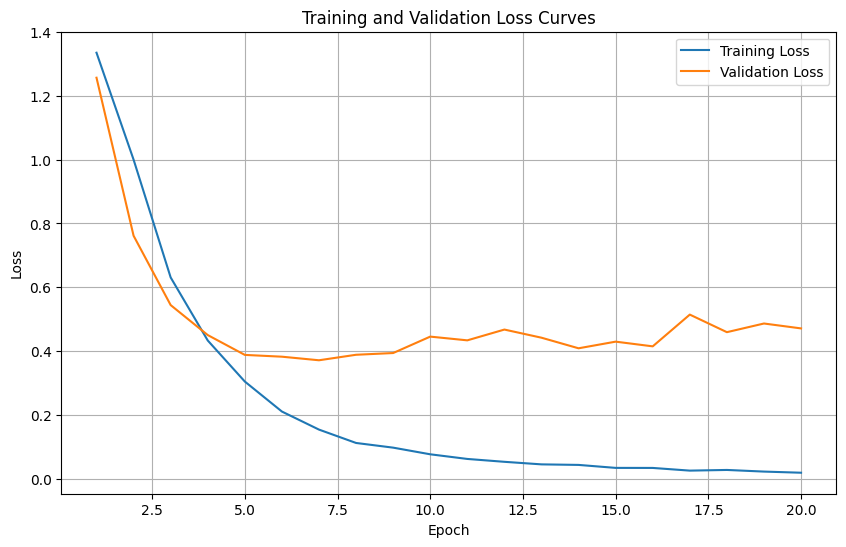

In [14]:
# plotting training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses)+1), train_losses, label="Training Loss")
plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curves")
plt.legend()
plt.grid(True)
plt.savefig("loss_curves.png")
plt.show()

Test Loss: 0.4251, Test Accuracy: 87.24%


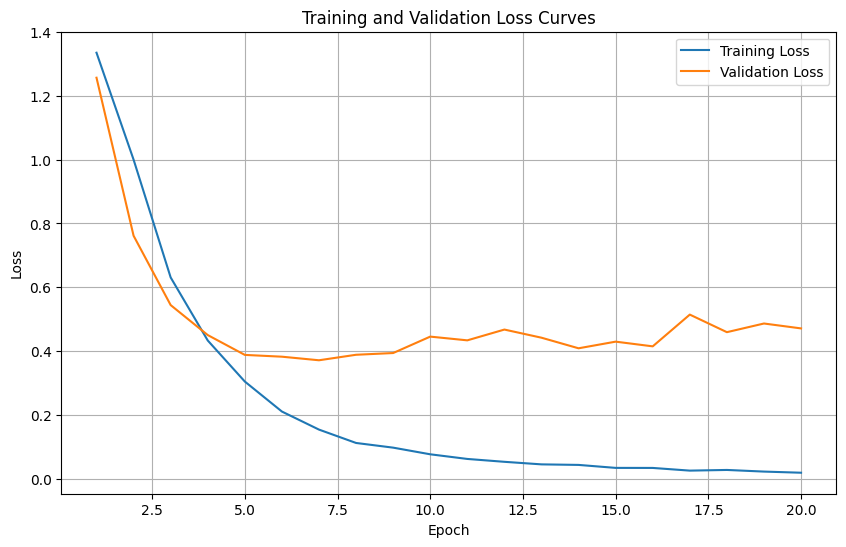


Classification Report:
               precision    recall  f1-score   support

       angry       0.94      0.85      0.89       140
       happy       0.90      0.93      0.92       148
     relaxed       0.81      0.87      0.84       146
         sad       0.84      0.83      0.84       138

    accuracy                           0.87       572
   macro avg       0.87      0.87      0.87       572
weighted avg       0.87      0.87      0.87       572



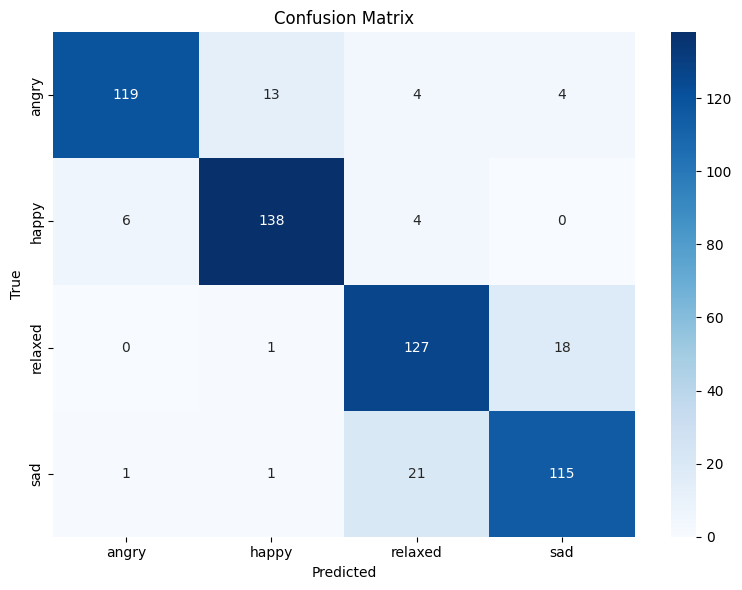

In [15]:
# load best model from training 
final_model.load_state_dict(torch.load(best_model_path)) 
final_model.to(device) 
final_model.eval() 
 
# initialise metrics 
correct = 0 
total = 0 
test_loss = 0.0 
all_preds = [] 
all_labels = [] 
 
with torch.no_grad(): 
    for images, labels in FULL_TEST_LOADER: 
        images, labels = images.to(device), labels.to(device) 
        outputs = final_model(images) 
        # for test loss 
        loss = criterion(outputs, labels) 
        test_loss += loss.item() * images.size(0) 
        # for accuracy 
        _, predicted = torch.max(outputs, 1) 
        total += labels.size(0) 
        correct += (predicted == labels).sum().item() 
 
        all_preds.extend(predicted.cpu().numpy()) # move to cpu to ensure compatibility because numpy only operates on cpu 
        all_labels.extend(labels.cpu().numpy()) 
 
test_loss = test_loss / len(FULL_TEST_LOADER.dataset) 
test_accuracy = correct / total 
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%") 
logging.info("Test Loss: %.4f, Test Accuracy: %.2f%%", test_loss, test_accuracy * 100) 
 
# plotting training and validation loss curves 
if 'train_losses' in globals() and 'val_losses' in globals(): 
    plt.figure(figsize=(10, 6)) 
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Training Loss") 
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss") 
    plt.xlabel("Epoch") 
    plt.ylabel("Loss") 
    plt.title("Training and Validation Loss Curves") 
    plt.legend() 
    plt.grid(True) 
    loss_curve_path = os.path.join("..", "results", modelName, "loss_curves.png") #NOTE: specify by model name 
    plt.savefig(loss_curve_path) 
    plt.show() 
    logging.info("Training and Validation Loss curves saved to %s", loss_curve_path) 
else: 
    logging.warning("train_losses and val_losses are not defined. Skipping loss curves plot.") 
 
# generate and log classification report 
class_names = FULL_TEST_LOADER.dataset.classes 
report = classification_report(all_labels, all_preds, target_names=class_names) 
print("\nClassification Report:\n", report) 
logging.info("Classification Report:\n%s", report) 
 
# generate confusion matrix 
cm = confusion_matrix(all_labels, all_preds) 
 
# save confusion matrix as image 
fig, ax = plt.subplots(figsize=(8, 6)) 
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax) 
plt.xlabel("Predicted") 
plt.ylabel("True") 
plt.title("Confusion Matrix") 
plt.tight_layout() 
 
conf_matrix_path = os.path.join("..", "results", modelName, "confusion_matrix.png") #NOTE: specify by model name 
fig.savefig(conf_matrix_path) 
plt.show(fig) 
 
logging.info("Confusion matrix saved to: %s", conf_matrix_path)
